In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb
from tqdm import tqdm

#### Output file

In [2]:
sourceFile = open("gpu_logs/loureiro_meteo.txt", 'w')

### Load the data

In [8]:
merged = pd.read_csv("data/loureiro_meteo.csv")
merged

,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,Rad_Total,Energy
0,2022-05-05 12:00:00,Energy_1,16.80,16.90,16.60,167.0,179.0,1.40,2.40,0.00,0.0,0.068
1,2022-05-05 12:15:00,Energy_1,16.65,16.85,16.50,172.0,165.5,1.55,2.45,0.00,0.0,0.070
2,2022-05-05 12:30:00,Energy_1,16.50,16.60,16.40,171.0,175.0,1.20,2.30,0.00,0.0,0.122
3,2022-05-05 12:45:00,Energy_1,16.40,16.60,16.30,167.0,171.5,1.20,2.30,0.00,0.0,0.132
4,2022-05-05 13:00:00,Energy_1,16.40,16.50,16.40,163.0,172.0,1.30,2.50,0.00,0.0,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...
1520755,2023-06-07 01:15:00,Energy_164,16.40,16.50,16.30,340.0,338.0,2.50,3.40,0.00,0.0,0.003
1520756,2023-06-07 01:30:00,Energy_164,16.40,16.50,16.35,335.0,338.5,2.05,2.90,0.05,0.0,0.004
1520757,2023-06-07 01:45:00,Energy_164,16.50,16.50,16.40,333.0,313.0,1.80,2.70,0.10,0.3,0.003
1520758,2023-06-07 02:00:00,Energy_164,16.50,16.60,16.40,337.5,342.0,2.20,2.90,0.05,0.0,0.004


In [4]:
missing_values = merged.isna().sum()
selected_columns = merged.columns[np.where(missing_values <= 1000)]
df = merged[selected_columns]
print(df.isna().sum().sum())
df

0


,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,Rad_Total,Energy
0,2022-05-05 12:00:00,Energy_1,16.80,16.90,16.60,167.0,179.0,1.40,2.40,0.00,0.0,0.068
1,2022-05-05 12:15:00,Energy_1,16.65,16.85,16.50,172.0,165.5,1.55,2.45,0.00,0.0,0.070
2,2022-05-05 12:30:00,Energy_1,16.50,16.60,16.40,171.0,175.0,1.20,2.30,0.00,0.0,0.122
3,2022-05-05 12:45:00,Energy_1,16.40,16.60,16.30,167.0,171.5,1.20,2.30,0.00,0.0,0.132
4,2022-05-05 13:00:00,Energy_1,16.40,16.50,16.40,163.0,172.0,1.30,2.50,0.00,0.0,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...
1520755,2023-06-07 01:15:00,Energy_164,16.40,16.50,16.30,340.0,338.0,2.50,3.40,0.00,0.0,0.003
1520756,2023-06-07 01:30:00,Energy_164,16.40,16.50,16.35,335.0,338.5,2.05,2.90,0.05,0.0,0.004
1520757,2023-06-07 01:45:00,Energy_164,16.50,16.50,16.40,333.0,313.0,1.80,2.70,0.10,0.3,0.003
1520758,2023-06-07 02:00:00,Energy_164,16.50,16.60,16.40,337.5,342.0,2.20,2.90,0.05,0.0,0.004


In [5]:
zero_values = np.sum(df == 0)
selected_columns = df.columns[np.where(zero_values < 5000)]
df = df[selected_columns]
print(np.where(np.sum(df == 0) > 1000)[0])
df

[5]


,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Intensidade_Vento_Med,Intensidade_Vento_Max
0,2022-05-05 12:00:00,Energy_1,16.80,16.90,16.60,167.0,1.40,2.40
1,2022-05-05 12:15:00,Energy_1,16.65,16.85,16.50,172.0,1.55,2.45
2,2022-05-05 12:30:00,Energy_1,16.50,16.60,16.40,171.0,1.20,2.30
3,2022-05-05 12:45:00,Energy_1,16.40,16.60,16.30,167.0,1.20,2.30
4,2022-05-05 13:00:00,Energy_1,16.40,16.50,16.40,163.0,1.30,2.50
...,...,...,...,...,...,...,...,...
1520755,2023-06-07 01:15:00,Energy_164,16.40,16.50,16.30,340.0,2.50,3.40
1520756,2023-06-07 01:30:00,Energy_164,16.40,16.50,16.35,335.0,2.05,2.90
1520757,2023-06-07 01:45:00,Energy_164,16.50,16.50,16.40,333.0,1.80,2.70
1520758,2023-06-07 02:00:00,Energy_164,16.50,16.60,16.40,337.5,2.20,2.90


### Interpolate missing values

In [7]:
df.index = pd.to_datetime(df["Time"])
df.drop(["Time"], inplace=True, axis=1)
for column in df.columns:
    df[column] = df[column].interpolate(method='time', limit_direction="both")
print(df.isna().sum().sum())
df["Time"] = df.index
df.reset_index(drop=True, inplace=True)
column_names = df.columns.tolist()
column_to_move = 'Time'
column_names.remove(column_to_move)
new_column_order = [column_to_move] + column_names
df = df[new_column_order]
df

0


/tmp/ipykernel_614485/3669999027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["Time"], inplace=True, axis=1)
/tmp/ipykernel_614485/3669999027.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].interpolate(method='time', limit_direction="both")
/tmp/ipykernel_614485/3669999027.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Intensidade_Vento_Med,Intensidade_Vento_Max
0,2022-05-05 12:00:00,Energy_1,16.80,16.90,16.60,167.0,1.40,2.40
1,2022-05-05 12:15:00,Energy_1,16.65,16.85,16.50,172.0,1.55,2.45
2,2022-05-05 12:30:00,Energy_1,16.50,16.60,16.40,171.0,1.20,2.30
3,2022-05-05 12:45:00,Energy_1,16.40,16.60,16.30,167.0,1.20,2.30
4,2022-05-05 13:00:00,Energy_1,16.40,16.50,16.40,163.0,1.30,2.50
...,...,...,...,...,...,...,...,...
1520755,2023-06-07 01:15:00,Energy_164,16.40,16.50,16.30,340.0,2.50,3.40
1520756,2023-06-07 01:30:00,Energy_164,16.40,16.50,16.35,335.0,2.05,2.90
1520757,2023-06-07 01:45:00,Energy_164,16.50,16.50,16.40,333.0,1.80,2.70
1520758,2023-06-07 02:00:00,Energy_164,16.50,16.60,16.40,337.5,2.20,2.90


In [ ]:
df.to_csv("data/loureiro_40casas.csv", index=None)

In [9]:
np.sum(df == 0)

Time                        0
Location                    0
Temp_Med                    0
Temp_Max                    0
Temp_Min                   80
Rumo_Vento_Med           2880
Intensidade_Vento_Med      40
Intensidade_Vento_Max       0
dtype: int64

### Auxiliary functions

In [10]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    print('MSE: %.4f' % mse)
    print('WAPE: %.2f' % wape)
    print('R2: %.4f' % r2)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores

In [11]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)))
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)))

def past_timesteps(df, number_of_timesteps):
    df = df.sort_values(by=['Location', 'Time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [12]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [13]:
def test_leave_house_out(df, estimator, locations, filename):
    test = df[df['Location'].isin(locations)]
    train = df[~df['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)
    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Save Dataframe with past timesteps

In [14]:
df = pd.read_csv("data/loureiro_meteo.csv")
df.Time = pd.to_datetime(df.Time)
df

,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,Rad_Total,Energy
0,2022-05-05 12:00:00,Energy_1,16.80,16.90,16.60,167.0,179.0,1.40,2.40,0.00,0.0,0.068
1,2022-05-05 12:15:00,Energy_1,16.65,16.85,16.50,172.0,165.5,1.55,2.45,0.00,0.0,0.070
2,2022-05-05 12:30:00,Energy_1,16.50,16.60,16.40,171.0,175.0,1.20,2.30,0.00,0.0,0.122
3,2022-05-05 12:45:00,Energy_1,16.40,16.60,16.30,167.0,171.5,1.20,2.30,0.00,0.0,0.132
4,2022-05-05 13:00:00,Energy_1,16.40,16.50,16.40,163.0,172.0,1.30,2.50,0.00,0.0,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...
1520755,2023-06-07 01:15:00,Energy_164,16.40,16.50,16.30,340.0,338.0,2.50,3.40,0.00,0.0,0.003
1520756,2023-06-07 01:30:00,Energy_164,16.40,16.50,16.35,335.0,338.5,2.05,2.90,0.05,0.0,0.004
1520757,2023-06-07 01:45:00,Energy_164,16.50,16.50,16.40,333.0,313.0,1.80,2.70,0.10,0.3,0.003
1520758,2023-06-07 02:00:00,Energy_164,16.50,16.60,16.40,337.5,342.0,2.20,2.90,0.05,0.0,0.004


In [16]:
number_of_timesteps = 672

In [17]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

 14%|█▍        | 95/672 [00:02<00:12, 45.90it/s]/tmp/ipykernel_614485/614070474.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"lag_{i}"] = df['Energy'].shift(i)
/tmp/ipykernel_614485/614070474.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"lag_{i}"] = df['Energy'].shift(i)
/tmp/ipykernel_614485/614070474.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usua

,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,...,lag_663,lag_664,lag_665,lag_666,lag_667,lag_668,lag_669,lag_670,lag_671,lag_672
0,2022-05-12 12:00:00,Energy_1,20.6,20.90,20.30,359.0,359.0,6.30,10.40,0.00,...,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122,0.070,0.068
1,2022-05-12 12:15:00,Energy_1,20.2,20.45,20.00,2.0,6.5,6.65,10.05,0.00,...,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122,0.070
2,2022-05-12 12:30:00,Energy_1,20.1,20.30,19.90,360.0,1.0,6.40,9.80,0.00,...,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122
3,2022-05-12 12:45:00,Energy_1,20.0,20.25,19.85,180.0,185.5,6.40,10.10,0.00,...,0.096,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132
4,2022-05-12 13:00:00,Energy_1,20.2,20.40,19.90,1.0,10.0,5.90,9.40,0.00,...,0.093,0.096,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.4,16.50,16.30,340.0,338.0,2.50,3.40,0.00,...,0.009,0.010,0.027,0.038,0.037,0.009,0.010,0.009,0.010,0.023
1413236,2023-06-07 01:30:00,Energy_96,16.4,16.50,16.35,335.0,338.5,2.05,2.90,0.05,...,0.010,0.009,0.010,0.027,0.038,0.037,0.009,0.010,0.009,0.010
1413237,2023-06-07 01:45:00,Energy_96,16.5,16.50,16.40,333.0,313.0,1.80,2.70,0.10,...,0.009,0.010,0.009,0.010,0.027,0.038,0.037,0.009,0.010,0.009
1413238,2023-06-07 02:00:00,Energy_96,16.5,16.60,16.40,337.5,342.0,2.20,2.90,0.05,...,0.035,0.009,0.010,0.009,0.010,0.027,0.038,0.037,0.009,0.010


In [18]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,...,lag_666,lag_667,lag_668,lag_669,lag_670,lag_671,lag_672,DayOfWeek,Weekend,Hour
0,2022-05-12 12:00:00,Energy_1,20.6,20.90,20.30,359.0,359.0,6.30,10.40,0.00,...,0.112,0.089,0.125,0.132,0.122,0.070,0.068,3,0,12
1,2022-05-12 12:15:00,Energy_1,20.2,20.45,20.00,2.0,6.5,6.65,10.05,0.00,...,0.111,0.112,0.089,0.125,0.132,0.122,0.070,3,0,12
2,2022-05-12 12:30:00,Energy_1,20.1,20.30,19.90,360.0,1.0,6.40,9.80,0.00,...,0.091,0.111,0.112,0.089,0.125,0.132,0.122,3,0,12
3,2022-05-12 12:45:00,Energy_1,20.0,20.25,19.85,180.0,185.5,6.40,10.10,0.00,...,0.156,0.091,0.111,0.112,0.089,0.125,0.132,3,0,12
4,2022-05-12 13:00:00,Energy_1,20.2,20.40,19.90,1.0,10.0,5.90,9.40,0.00,...,0.377,0.156,0.091,0.111,0.112,0.089,0.125,3,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.4,16.50,16.30,340.0,338.0,2.50,3.40,0.00,...,0.038,0.037,0.009,0.010,0.009,0.010,0.023,2,0,1
1413236,2023-06-07 01:30:00,Energy_96,16.4,16.50,16.35,335.0,338.5,2.05,2.90,0.05,...,0.027,0.038,0.037,0.009,0.010,0.009,0.010,2,0,1
1413237,2023-06-07 01:45:00,Energy_96,16.5,16.50,16.40,333.0,313.0,1.80,2.70,0.10,...,0.010,0.027,0.038,0.037,0.009,0.010,0.009,2,0,1
1413238,2023-06-07 02:00:00,Energy_96,16.5,16.60,16.40,337.5,342.0,2.20,2.90,0.05,...,0.009,0.010,0.027,0.038,0.037,0.009,0.010,2,0,2


In [19]:
df_new.to_csv("data/loureiro_meteo_oneweek.csv", index=False)

## Predict  5 folds with 10 random houses for test

In [20]:
df = pd.read_csv("data/loureiro_meteo_oneweek.csv")
df

,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,...,lag_666,lag_667,lag_668,lag_669,lag_670,lag_671,lag_672,DayOfWeek,Weekend,Hour
0,2022-05-12 12:00:00,Energy_1,20.6,20.90,20.30,359.0,359.0,6.30,10.40,0.00,...,0.112,0.089,0.125,0.132,0.122,0.070,0.068,3,0,12
1,2022-05-12 12:15:00,Energy_1,20.2,20.45,20.00,2.0,6.5,6.65,10.05,0.00,...,0.111,0.112,0.089,0.125,0.132,0.122,0.070,3,0,12
2,2022-05-12 12:30:00,Energy_1,20.1,20.30,19.90,360.0,1.0,6.40,9.80,0.00,...,0.091,0.111,0.112,0.089,0.125,0.132,0.122,3,0,12
3,2022-05-12 12:45:00,Energy_1,20.0,20.25,19.85,180.0,185.5,6.40,10.10,0.00,...,0.156,0.091,0.111,0.112,0.089,0.125,0.132,3,0,12
4,2022-05-12 13:00:00,Energy_1,20.2,20.40,19.90,1.0,10.0,5.90,9.40,0.00,...,0.377,0.156,0.091,0.111,0.112,0.089,0.125,3,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.4,16.50,16.30,340.0,338.0,2.50,3.40,0.00,...,0.038,0.037,0.009,0.010,0.009,0.010,0.023,2,0,1
1413236,2023-06-07 01:30:00,Energy_96,16.4,16.50,16.35,335.0,338.5,2.05,2.90,0.05,...,0.027,0.038,0.037,0.009,0.010,0.009,0.010,2,0,1
1413237,2023-06-07 01:45:00,Energy_96,16.5,16.50,16.40,333.0,313.0,1.80,2.70,0.10,...,0.010,0.027,0.038,0.037,0.009,0.010,0.009,2,0,1
1413238,2023-06-07 02:00:00,Energy_96,16.5,16.60,16.40,337.5,342.0,2.20,2.90,0.05,...,0.009,0.010,0.027,0.038,0.037,0.009,0.010,2,0,2


In [21]:
df_selected = df[["Time","Location","Temp_Med","Temp_Max","Temp_Min","Rumo_Vento_Med","Rumo_Vento_Max","Intensidade_Vento_Med","Intensidade_Vento_Max","Precip","Rad_Total","lag_1","lag_2","lag_3","lag_4","lag_96","lag_192","lag_288","lag_384","lag_480","lag_576","lag_672","DayOfWeek","Hour","Energy"]]
df_selected

,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,...,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy
0,2022-05-12 12:00:00,Energy_1,20.6,20.90,20.30,359.0,359.0,6.30,10.40,0.00,...,0.041,0.023,0.044,0.033,0.032,0.057,0.068,3,12,0.039
1,2022-05-12 12:15:00,Energy_1,20.2,20.45,20.00,2.0,6.5,6.65,10.05,0.00,...,0.487,0.034,0.058,0.034,0.029,0.065,0.070,3,12,0.061
2,2022-05-12 12:30:00,Energy_1,20.1,20.30,19.90,360.0,1.0,6.40,9.80,0.00,...,0.340,0.037,0.038,0.055,0.047,0.030,0.122,3,12,0.038
3,2022-05-12 12:45:00,Energy_1,20.0,20.25,19.85,180.0,185.5,6.40,10.10,0.00,...,0.058,0.046,0.026,0.058,0.022,0.329,0.132,3,12,0.069
4,2022-05-12 13:00:00,Energy_1,20.2,20.40,19.90,1.0,10.0,5.90,9.40,0.00,...,0.044,0.024,0.026,0.036,0.020,0.329,0.125,3,13,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.4,16.50,16.30,340.0,338.0,2.50,3.40,0.00,...,0.015,0.041,0.032,0.009,0.010,0.010,0.023,2,1,0.009
1413236,2023-06-07 01:30:00,Energy_96,16.4,16.50,16.35,335.0,338.5,2.05,2.90,0.05,...,0.041,0.037,0.009,0.010,0.009,0.036,0.010,2,1,0.009
1413237,2023-06-07 01:45:00,Energy_96,16.5,16.50,16.40,333.0,313.0,1.80,2.70,0.10,...,0.038,0.016,0.010,0.009,0.020,0.039,0.009,2,1,0.040
1413238,2023-06-07 02:00:00,Energy_96,16.5,16.60,16.40,337.5,342.0,2.20,2.90,0.05,...,0.022,0.010,0.009,0.009,0.041,0.029,0.010,2,2,0.038


In [22]:
df_selected.to_csv("data/loureiro_meteo_selected.csv", index=None)

In [23]:
df_test = pd.read_csv("data/loureiro_meteo_selected.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("data/loureiro_meteo_selected.csv", engine='c', dtype=float32_cols)
df

,Time,Location,Temp_Med,Temp_Max,Temp_Min,Rumo_Vento_Med,Rumo_Vento_Max,Intensidade_Vento_Med,Intensidade_Vento_Max,Precip,...,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy
0,2022-05-12 12:00:00,Energy_1,20.600000,20.900000,20.299999,359.0,359.0,6.30,10.40,0.00,...,0.041,0.023,0.044,0.033,0.032,0.057,0.068,3,12,0.039
1,2022-05-12 12:15:00,Energy_1,20.200001,20.450001,20.000000,2.0,6.5,6.65,10.05,0.00,...,0.487,0.034,0.058,0.034,0.029,0.065,0.070,3,12,0.061
2,2022-05-12 12:30:00,Energy_1,20.100000,20.299999,19.900000,360.0,1.0,6.40,9.80,0.00,...,0.340,0.037,0.038,0.055,0.047,0.030,0.122,3,12,0.038
3,2022-05-12 12:45:00,Energy_1,20.000000,20.250000,19.850000,180.0,185.5,6.40,10.10,0.00,...,0.058,0.046,0.026,0.058,0.022,0.329,0.132,3,12,0.069
4,2022-05-12 13:00:00,Energy_1,20.200001,20.400000,19.900000,1.0,10.0,5.90,9.40,0.00,...,0.044,0.024,0.026,0.036,0.020,0.329,0.125,3,13,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.400000,16.500000,16.299999,340.0,338.0,2.50,3.40,0.00,...,0.015,0.041,0.032,0.009,0.010,0.010,0.023,2,1,0.009
1413236,2023-06-07 01:30:00,Energy_96,16.400000,16.500000,16.350000,335.0,338.5,2.05,2.90,0.05,...,0.041,0.037,0.009,0.010,0.009,0.036,0.010,2,1,0.009
1413237,2023-06-07 01:45:00,Energy_96,16.500000,16.500000,16.400000,333.0,313.0,1.80,2.70,0.10,...,0.038,0.016,0.010,0.009,0.020,0.039,0.009,2,1,0.040
1413238,2023-06-07 02:00:00,Energy_96,16.500000,16.600000,16.400000,337.5,342.0,2.20,2.90,0.05,...,0.022,0.010,0.009,0.009,0.041,0.029,0.010,2,2,0.038


In [ ]:
#df = df[["Time", "Location", "energy_lag_1", "energy_lag_3", "energy_lag_95", "energy_lag_671", "Energy"]]
#df

In [24]:
num_houses_test = 8
locations = []
for i in range(10):
    np.random.seed(i*5)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['Energy_161', 'Energy_16', 'Energy_2', 'Energy_118', 'Energy_132',
        'Energy_146', 'Energy_48', 'Energy_135'], dtype=object),
 array(['Energy_16', 'Energy_161', 'Energy_17', 'Energy_117', 'Energy_164',
        'Energy_125', 'Energy_118', 'Energy_96'], dtype=object),
 array(['Energy_110', 'Energy_35', 'Energy_90', 'Energy_60', 'Energy_142',
        'Energy_139', 'Energy_126', 'Energy_17'], dtype=object),
 array(['Energy_60', 'Energy_16', 'Energy_148', 'Energy_65', 'Energy_17',
        'Energy_78', 'Energy_142', 'Energy_117'], dtype=object),
 array(['Energy_118', 'Energy_35', 'Energy_164', 'Energy_108',
        'Energy_139', 'Energy_94', 'Energy_2', 'Energy_142'], dtype=object),
 array(['Energy_161', 'Energy_90', 'Energy_125', 'Energy_135',
        'Energy_159', 'Energy_35', 'Energy_132', 'Energy_142'],
       dtype=object),
 array(['Energy_129', 'Energy_160', 'Energy_123', 'Energy_159',
        'Energy_65', 'Energy_127', 'Energy_35', 'Energy_146'], dtype=object),
 array(['

In [25]:
## Number of NaNs
df.isna().sum().sum()

0

In [26]:
df.Location.value_counts()

Energy_1      35331
Energy_108    35331
Energy_161    35331
Energy_164    35331
Energy_17     35331
Energy_2      35331
Energy_30     35331
Energy_35     35331
Energy_48     35331
Energy_58     35331
Energy_60     35331
Energy_65     35331
Energy_78     35331
Energy_86     35331
Energy_9      35331
Energy_90     35331
Energy_91     35331
Energy_94     35331
Energy_95     35331
Energy_160    35331
Energy_16     35331
Energy_159    35331
Energy_129    35331
Energy_110    35331
Energy_117    35331
Energy_118    35331
Energy_123    35331
Energy_125    35331
Energy_126    35331
Energy_127    35331
Energy_132    35331
Energy_151    35331
Energy_135    35331
Energy_138    35331
Energy_139    35331
Energy_142    35331
Energy_146    35331
Energy_148    35331
Energy_15     35331
Energy_96     35331
Name: Location, dtype: int64

### Linear Regression

In [27]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))


Iteration 0
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0031
WAPE: 36.00
R2: 0.5823

Iteration 1
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0026
WAPE: 40.58
R2: 0.7586

Iteration 2
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0069
WAPE: 34.23
R2: 0.6791

Iteration 3
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0071
WAPE: 37.74
R2: 0.6961

Iteration 4
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0025
WAPE: 32.87
R2: 0.7705

Iteration 5
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0031
WAPE: 36.62
R2: 0.6925

Iteration 6
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0043
WAPE: 39.06
R2: 0.5560

Iteration 7
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0029
WAPE: 37.26
R2: 0.6321

Iteration 8
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0027
WAPE: 42.78
R2: 0.6032

Iteration 9
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0047
WAPE: 34.44
R2: 0.7029


### XGBoost

In [28]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=1000), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))


Iteration 0
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0033
WAPE: 38.07
R2: 0.5535

Iteration 1
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0032
WAPE: 42.89
R2: 0.7032

Iteration 2
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0072
WAPE: 35.20
R2: 0.6652

Iteration 3
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0075
WAPE: 38.60
R2: 0.6759

Iteration 4
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0028
WAPE: 34.65
R2: 0.7455

Iteration 5
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0035
WAPE: 39.69
R2: 0.6545

Iteration 6
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0043
WAPE: 39.49
R2: 0.5519

Iteration 7
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0030
WAPE: 38.68
R2: 0.6205

Iteration 8
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0028
WAPE: 43.99
R2: 0.5866

Iteration 9
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0049
WAPE: 35.36
R2: 0.6898


### Random Forest

In [29]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))


Iteration 0
Train set:  (1130592, 25)
Test set:  (282648, 25)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0033
WAPE: 37.35
R2: 0.5621

Iteration 1
Train set:  (1130592, 25)
Test set:  (282648, 25)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0031
WAPE: 40.73
R2: 0.7174

Iteration 2
Train set:  (1130592, 25)
Test set:  (282648, 25)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0071
WAPE: 34.07
R2: 0.6715

Iteration 3
Train set:  (1130592, 25)
Test set:  (282648, 25)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0075
WAPE: 37.74
R2: 0.6762

Iteration 4
Train set:  (1130592, 25)
Test set:  (282648, 25)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0027
WAPE: 33.50
R2: 0.7558

Iteration 5
Train set:  (1130592, 25)
Test set:  (282648, 25)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0033
WAPE: 37.12
R2: 0.6759

Iteration 6
Train set:  (1130592, 25)
Test set:  (282648, 25)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0042
WAPE: 38.69
R2: 0.5616

Iteration 7
Train set:  (1130592, 25)
Test set:  (282648, 25)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0029
WAPE: 37.47
R2: 0.6330

Iteration 8
Train set:  (1130592, 25)
Test set:  (282648, 25)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0028
WAPE: 43.47
R2: 0.5975

Iteration 9
Train set:  (1130592, 25)
Test set:  (282648, 25)
MSE: 0.0048
WAPE: 34.08
R2: 0.6998


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [30]:
print("\n\n\n", file=sourceFile)

In [31]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

Total Averaged MSE: 0.004
Total Averaged WAPE: 37.158
Total Averaged R2: 0.667


In [32]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

Total Averaged MSE: 0.004
Total Averaged WAPE: 38.662
Total Averaged R2: 0.645


In [33]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

Total Averaged MSE: 0.004
Total Averaged WAPE: 37.422
Total Averaged R2: 0.655


In [34]:
sourceFile.close()

### Feature Importance

In [35]:
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

XGBoost

Feature: 0, Score: 0.00928
Feature: 1, Score: 0.01168
Feature: 2, Score: 0.01522
Feature: 3, Score: 0.01284
Feature: 4, Score: 0.01306
Feature: 5, Score: 0.01360
Feature: 6, Score: 0.01428
Feature: 7, Score: 0.01335
Feature: 8, Score: 0.01794
Feature: 9, Score: 0.50913
Feature: 10, Score: 0.10131
Feature: 11, Score: 0.03026
Feature: 12, Score: 0.02074
Feature: 13, Score: 0.03001
Feature: 14, Score: 0.02227
Feature: 15, Score: 0.02180
Feature: 16, Score: 0.01801
Feature: 17, Score: 0.01987
Feature: 18, Score: 0.02256
Feature: 19, Score: 0.03468
Feature: 20, Score: 0.01848
Feature: 21, Score: 0.02963


In [36]:
model_xgb.feature_importances_

array([0.0092761 , 0.01168434, 0.01522429, 0.01284402, 0.01306439,
       0.01359956, 0.01428408, 0.0133494 , 0.01793661, 0.5091307 ,
       0.10130958, 0.03026173, 0.02074061, 0.03001108, 0.02226529,
       0.0217961 , 0.01800668, 0.01987118, 0.02255923, 0.03467834,
       0.01847761, 0.02962905], dtype=float32)

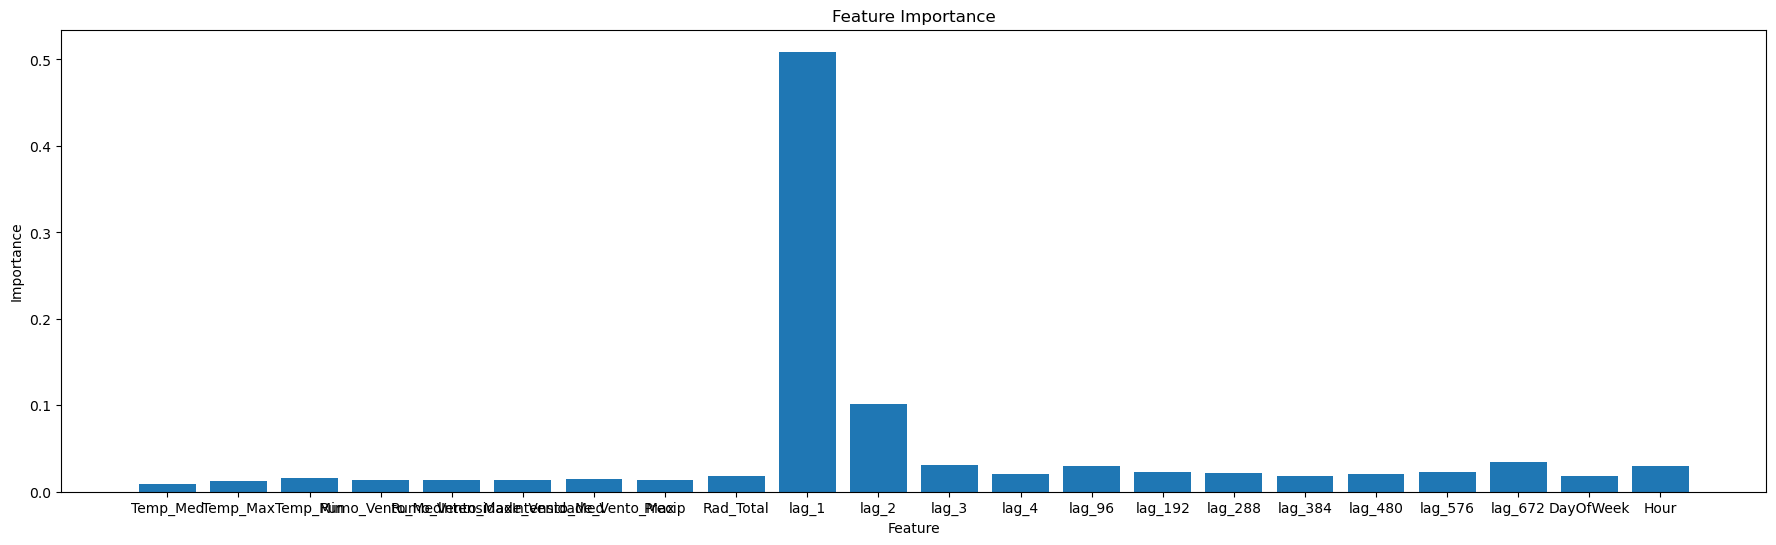

In [37]:
plt.figure(figsize=(22,6))
plt.bar(df.columns[2:-1],model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
#plt.savefig("images/porto_xgb_final7days_feature_importance.png")
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[2:-1],model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

## Hyperparameter Tuning

In [ ]:
df_tuning = pd.read_csv("data/loureiro_selected.csv")
df_tuning.drop(['Time', 'Location'],axis=1, inplace=True)
df_tuning

In [ ]:
params_rf = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
params_xgb = { 
    'max_depth': [3, 6, 10, 20, 50],
    'learning_rate': [0.01, 0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7]
}

In [ ]:
train_features = df_tuning.drop('Energy', axis=1)
train_labels = df_tuning['Energy']
test_features = 0
test_labels = 0

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor(seed=42, tree_method="gpu_hist")

grid_search = GridSearchCV(estimator = xgb_model, param_grid = params_xgb, cv = 5, n_jobs = 4, verbose = 2)

In [ ]:
grid_search.fit(train_features, train_labels)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = cuRF(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

best_random = grid_search.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
grid_search.best_params_
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))